In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np


full_data = pd.read_csv("execution_research_assignment_data.csv")
full_data.head()

c:\Users\joshu\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,DAY,EDGE,EDGE_EUR,VOLUME,GW,LATENCY,SUCCESS
0,0,0.012786,315.176118,29,2,7623,0
1,0,0.006832,87.106944,15,1,32989,0
2,0,0.008274,126.599008,18,1,3911,0
3,0,0.004841,24.688000,6,2,2674,0
4,0,0.000770,11.133152,17,1,27977,0


# Data Investigation

In [2]:
import pandas as pd

full_data = pd.read_csv("execution_research_assignment_data.csv")
full_data.head()

,DAY,EDGE,EDGE_EUR,VOLUME,GW,LATENCY,SUCCESS
0,0,0.012786,315.176118,29,2,7623,0
1,0,0.006832,87.106944,15,1,32989,0
2,0,0.008274,126.599008,18,1,3911,0
3,0,0.004841,24.688000,6,2,2674,0
4,0,0.000770,11.133152,17,1,27977,0


## Overall Statistics of the Data

Currency Conversion Per Order is Fixed at 850

In [3]:
# Currency Adjustment is a constant 850
vol_check = full_data.EDGE_EUR / full_data.EDGE
currency_adjust = vol_check / full_data.VOLUME
print(currency_adjust.min())
print(currency_adjust.max())


849.9999999999162
850.0000000008121


Roughly 10,000 orders sent each day

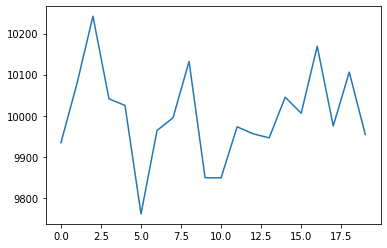

In [4]:
full_data.DAY.value_counts().sort_index().mean() # exactly 10ks
plt.plot(full_data.DAY.value_counts().sort_index())
#sns.boxplot(full_data.DAY.value_counts().sort_index())

Volume per order is roughly 17.6

16.983125753314585


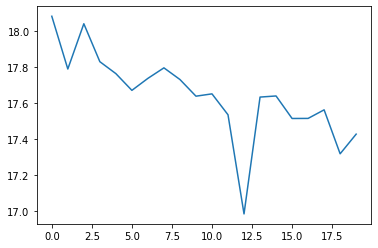

In [5]:
X = full_data.groupby("DAY").apply(lambda x:x.VOLUME.mean())
plt.plot(X)
plt.show
print(X.min())

## Irregular Data

### Negative Latency

In [6]:
neg_latency = full_data.loc[full_data.LATENCY<= 0]
print(neg_latency.shape)
print(neg_latency.describe())

(11370, 7)
                DAY          EDGE      EDGE_EUR        VOLUME            GW  \
count  11370.000000  1.137000e+04  11370.000000  11370.000000  11370.000000   
mean       9.672735  8.544269e-03    163.149253     17.652946      1.852858   
std        5.823671  6.451541e-03    191.768780      8.588994      1.100493   
min        0.000000  1.920488e-07      0.000000      0.000000      0.000000   
25%        4.000000  3.370846e-03     31.612955     11.000000      1.000000   
50%       10.000000  7.250166e-03     96.332495     17.000000      2.000000   
75%       15.000000  1.229052e-02    225.359865     23.000000      3.000000   
max       19.000000  4.333705e-02   1989.170414     55.000000      3.000000   

            LATENCY       SUCCESS  
count  11370.000000  11370.000000  
mean   -3212.858575      0.288566  
std     2634.445671      0.453116  
min   -18821.000000      0.000000  
25%    -4683.000000      0.000000  
50%    -2538.500000      0.000000  
75%    -1146.000000      

Negative Latency should not be possible (time cannot be negative) The possible reasons for such data are:
- Data is correct and negative latency indicates orders which are sent before event occurs (event is predicted and order sent before-hand)
    - This would explain the high success Rate of negative orders of 28.9%
- Data is an outlier / incorrect, so we can either mark it as NaN or remove the data
    - There is a large amount of negative Data, and the Distribution suggests there is a pattern to negative latency similar to positive so it is not just noise
- Latency of these order were incorrectly recorded and is -1*(recored value)
    - This the case if the negative latency is distributed the same as positive latency, but mirrored in y-axis
    - However the success rate of orders recored from 0 to 18821 latency does not match the distribution of success from 0 to -18821
- All Latency Data is shifted to the left 
    - We can correct data by adding 18821 (the minimum latency) to all values


Negative Latency Distribution 

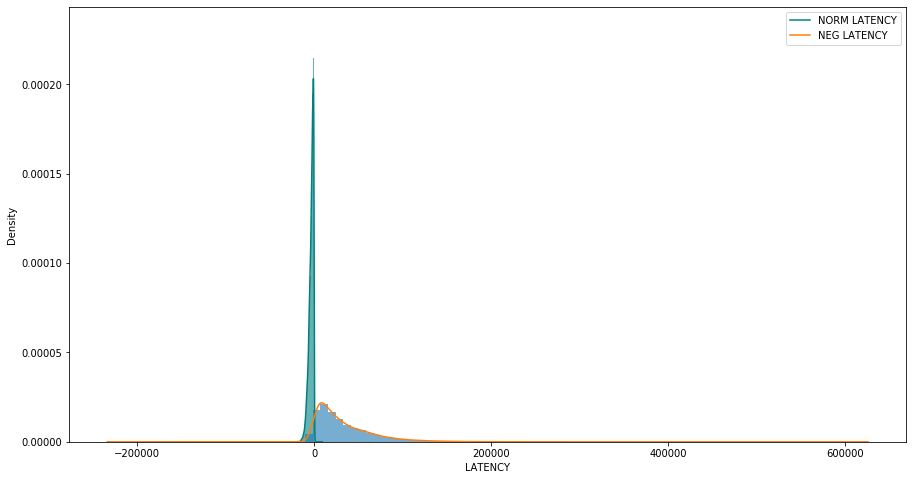

In [7]:
plt.figure(figsize=(15,8))
neg_latency = full_data.loc[full_data.LATENCY <= 0]
ax = neg_latency["LATENCY"].hist(bins=100, density=True, stacked=True, color='teal', alpha=0.6)
neg_latency["LATENCY"].plot(kind='density', color='teal')
ax.legend([ 'NEG LATENCY'])
ax.set(xlabel='NEG LATENCY')
ax = full_data["LATENCY"].hist(bins=50, density=True, stacked=True, alpha=0.6)
full_data["LATENCY"].plot(kind='density')
ax.legend([ 'NORM LATENCY',"NEG LATENCY"])
ax.set(xlabel='LATENCY')
#plt.xlim(-40000,85)
plt.show()

We see the distributions are not mirror images

What happens if negative latencies are *(-1)

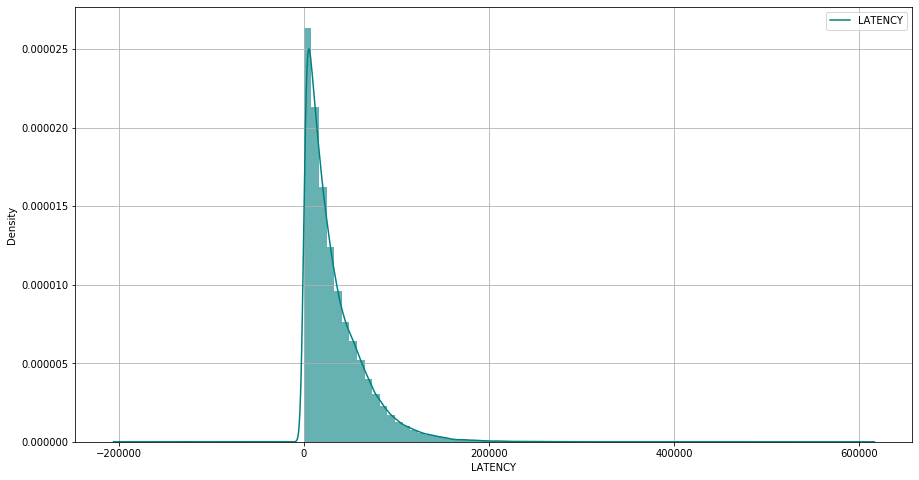

In [8]:
# multiply negative latencies
import numpy as np
flipped_data = full_data.copy()
flipped_data["New_Latency"] = np.where(flipped_data["LATENCY"] < 0 , flipped_data["LATENCY"] * -1, flipped_data["LATENCY"])
flipped_data.drop(["LATENCY"], axis=1,inplace=True)
flipped_data.rename(columns = {"New_Latency": "LATENCY"}, inplace=True)
plt.figure(figsize=(15,8))
ax = flipped_data["LATENCY"].hist(bins=50, density=True, stacked=True, color='teal', alpha=0.6)
flipped_data["LATENCY"].plot(kind='density', color='teal')
ax.legend([ 'LATENCY'])
ax.set(xlabel='LATENCY')
#plt.xlim(-40000,700000, )
#plt.xticks(np.arange(min(full_data["LATENCY"]), max(full_data["LATENCY"])+1, 100.0))
plt.grid()
plt.show()

Alternative is that the Latencies need to be shifted to the right

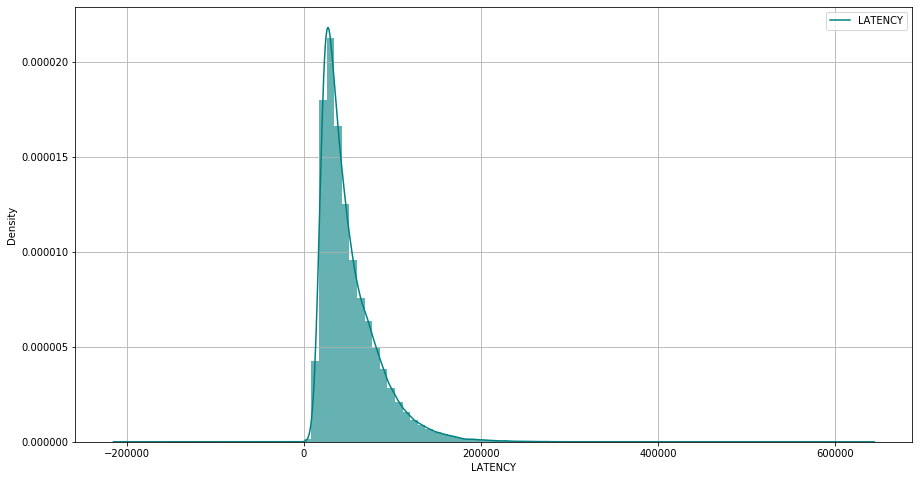

In [9]:
shifted_data = full_data.copy()
shifted_data.LATENCY = shifted_data.LATENCY + 18821 
plt.figure(figsize=(15,8))
ax = shifted_data["LATENCY"].hist(bins=50, density=True, stacked=True, color='teal', alpha=0.6)
shifted_data["LATENCY"].plot(kind='density', color='teal')
ax.legend([ 'LATENCY'])
ax.set(xlabel='LATENCY')
#plt.xlim(-40000,700000, )
#plt.xticks(np.arange(min(full_data["LATENCY"]), max(full_data["LATENCY"])+1, 100.0))
plt.grid()
plt.show()

Initially the Distribution of Latency is has an expected shape (positively skewed and decrease as we get to zero latency)
- Multiplying negative latencies by -1 worsens the distribution
- Shifting the latencies does not make a difference to calculations, so we shall leave negative latencies in the data for simplicity 

### Zero Volume Orders

In [10]:
zero_orders = full_data.loc[full_data.VOLUME <= 0]
print(len(zero_orders))
print(zero_orders[["EDGE","SUCCESS"]].describe())


750
               EDGE     SUCCESS
count  7.500000e+02  750.000000
mean   4.946968e-04    0.297333
std    2.974240e-04    0.457390
min    8.474882e-07    0.000000
25%    2.258575e-04    0.000000
50%    4.878417e-04    0.000000
75%    7.597582e-04    1.000000
max    9.998234e-04    1.000000


- 750 elemnts contain Orders of 0 volume
    - very small number of orders have zero Volume
    - These orders have high success rate of 29.7%
    - Very low average edge of 0.0005 compared to 0.0086
    - EDGE_EURO is 0 as expected

These orders can be removed and counted as noise

### High Latency on Day 5

21333.894736842107

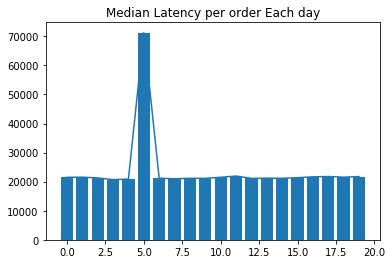

In [11]:
edge_day = full_data.groupby("DAY").apply(lambda x:x.LATENCY.median())
x = [i for i in range(20)]
plt.bar(x,edge_day)
plt.plot(edge_day)
plt.title("Median Latency per order Each day")

edge_day.sort_values(ascending=False, inplace=True)
edge_day.iloc[0]
#edge_day.pop(0)  # after re ordering index

edge_day.drop(edge_day.idxmax(), inplace=True)
edge_day.head()
edge_day.mean() # avearge latency

The average / median latency is consistent each day
- Day 5 is 
- This could occur because opportunities were overall of lower EDGE compared to average
    -  Therefore average Latency is higher as it would take longer to recognise an event as an opportunity, and longer to decide on Order as lower Edge opportunities are higher risk

### Low EDGE per Order on Day 12

Text(0.5, 1.0, 'Average Edge per order Each Day')

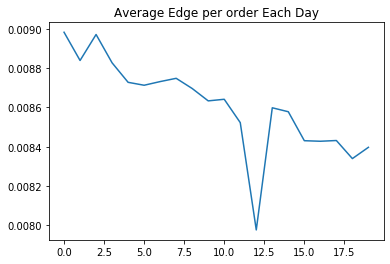

In [12]:
edge_day = full_data.groupby("DAY").apply(lambda x:x.EDGE.mean())
x = [i for i in range(20)]

plt.plot(edge_day)
plt.title("Average Edge per order Each Day")

Average EDGE per order decreases over time, and a small dip is observedat DAY 5 
- A large dip is seen at DAY 12
    - However There is no spike in latency meaning that there may have been an overall market shift in EDGE on day 12

We see that Day 12 also has a lower than normal amount of Orders, which indicates that there happened to be fewer opportunites in the market on day 12

#### Edge Euro trends like EDGE

12


Text(0.5, 1.0, 'Average Edge_EURO per order Each Day')

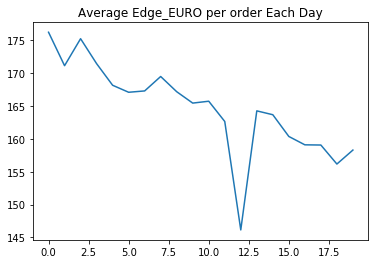

In [13]:
edge_day = full_data.groupby("DAY").apply(lambda x:x.EDGE_EUR.mean())
print(edge_day.idxmin())
x = [i for i in range(20)]
#plt.bar(x,edge_day)
plt.plot(edge_day)
plt.title("Average Edge_EURO per order Each Day")
#edge_day.sort_values(ascending=True)



## Outliers and Data Cleaning

### Latency

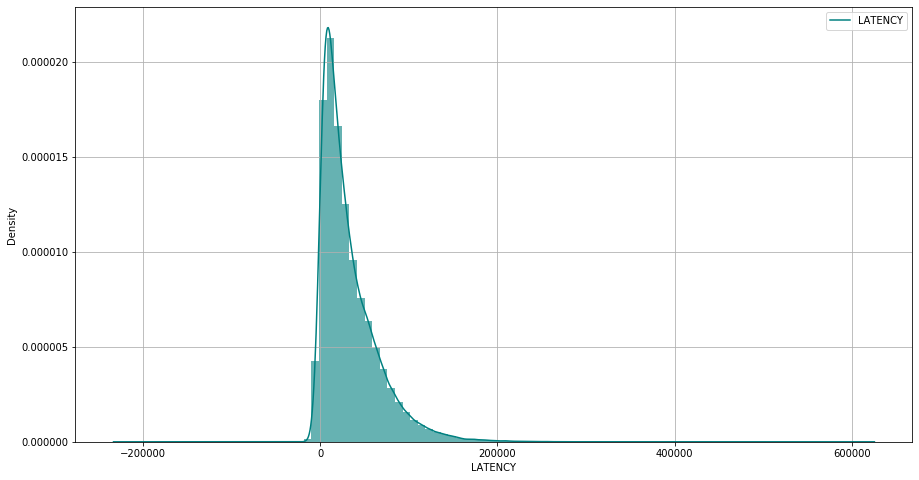

In [14]:
plt.figure(figsize=(15,8))

ax = full_data["LATENCY"].hist(bins=50, density=True, stacked=True, color='teal', alpha=0.6)
full_data["LATENCY"].plot(kind='density', color='teal')
ax.legend([ 'LATENCY'])
ax.set(xlabel='LATENCY')
#plt.xlim(-40000,700000, )
#plt.xticks(np.arange(min(full_data["LATENCY"]), max(full_data["LATENCY"])+1, 100.0))
plt.grid()
plt.show()

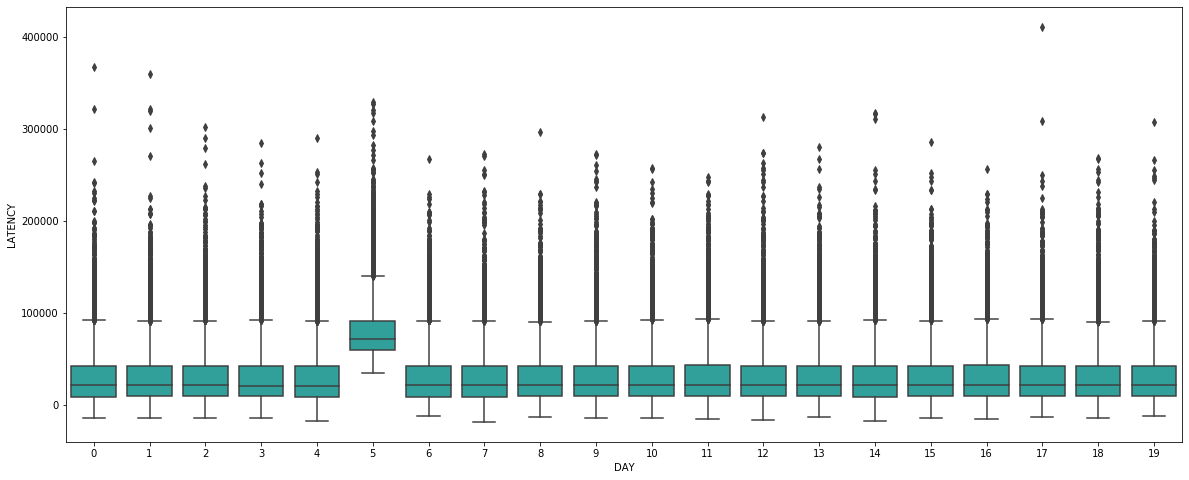

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(20,8))
avg_survival_byage = full_data[["DAY", "LATENCY"]]#.groupby(['DAY'], as_index=False)
g = sns.boxplot(x='DAY', y='LATENCY', data=avg_survival_byage, color="LightSeaGreen")
# a lot of outliers
plt.show()

Rather than Looking at Latency through the entire Data set, we shall select outliers based on daily Latency
- We see that Latency is distributed the same each day, however many DAY 5 results would be removed if total latency was grouped 
- grouping Latency together and removing outliers in general does not account for intra day latency

Latency Outliers selected By IQR:
High outlier ≥ Q3 + (1.5 x IQR)
Low outlier ≤ Q1 − (1.5 x IQR)

In [16]:
# Split by day
Tot = 0
for i in range(20):
    Q2 = full_data.loc[full_data.DAY == i].LATENCY.quantile(0.25)
    Q3 = full_data.loc[full_data.DAY == i].LATENCY.quantile(0.75)
    IQR = Q3 - Q2
    Outlier_H = 1.5 * IQR + Q3
    Outlier_L = -1.5 * IQR + Q2
    high_outlier = full_data.loc[(full_data.DAY == i) & (full_data.LATENCY > Outlier_H)].LATENCY.count()
    low_outlier = full_data.loc[(full_data.DAY == i) & (full_data.LATENCY < Outlier_L)].LATENCY.count()
    
    #print("Total Number of High outliers: ", high_outlier)
    #print("Total Number of Low outliers: ",  low_outlier)
    #print("Total Number of outliers: ", high_outlier + low_outlier)
    #print("Percentage of Values", 100*(high_outlier + low_outlier) / len(full_data.loc[full_data.DAY == i]))
    Tot = Tot + high_outlier + low_outlier

print("Total portion that are outliers: " ,100*Tot / len(full_data),"%")


Total portion that are outliers:  4.7595 %


### Cleaned Data

In [72]:
### 
X = full_data.copy()
outliers_day = pd.DataFrame([])
for i in range(20):
    Q2 = X.loc[X.DAY == i].LATENCY.quantile(0.25)
    Q3 = X.loc[X.DAY == i].LATENCY.quantile(0.75)
    IQR = Q3 - Q2
    Outlier_H = 1.5 * IQR + Q3
    Outlier_L = -1.5 * IQR + Q2
    y = X.drop(X[(X.LATENCY < Outlier_L) & (X.DAY ==i)].index, inplace=True)
    X.drop(X[(X.LATENCY > Outlier_H) & (X.DAY == i)].index, inplace=True)
    #X.drop(X[X.LATENCY < low_outlier], inplace=True)
Latency_cleaned_data = X.copy()

cleaned_data = Latency_cleaned_data.drop(Latency_cleaned_data[Latency_cleaned_data.VOLUME == 0].index)

# Now just use full data as cleaned

full_data = cleaned_data.copy()

# Explainatory Data Analysis

### Success rate Each Day

0.16625094892094133


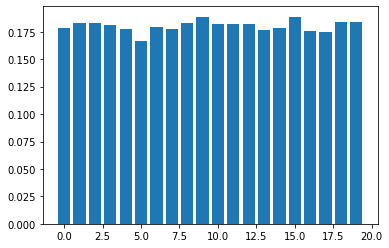

In [18]:
X = []
for i in range(20):
    X.append(cleaned_data.loc[cleaned_data.DAY == i].SUCCESS.mean())
plt.bar([i for i in range(20)],X)
print(min(X))

### Success Rate of Orders Throughout the day

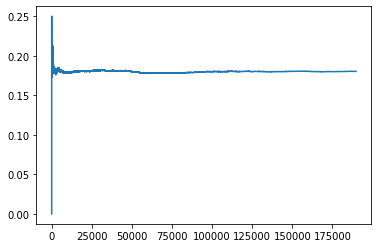

18.031154158279143


In [19]:
succ_overtime = []
num_succ, num_fail = 0,0
for i in full_data.SUCCESS:
    if i == 1:
        num_succ += 1
    else:
        num_fail+=1

    curr_val = num_succ / (num_succ + num_fail)
    succ_overtime.append(curr_val)
plt.plot(succ_overtime[:])
plt.show()
print(succ_overtime[-1]*100)

# 18% success over all orders
# stays steady over time


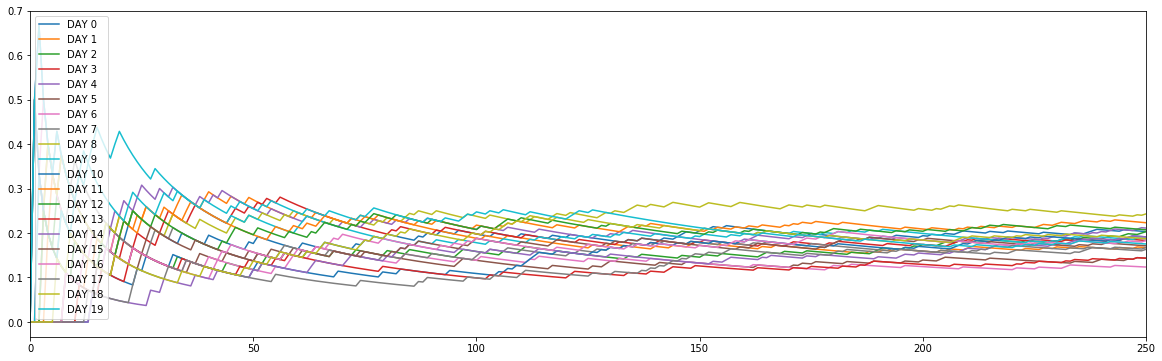

In [20]:
day = 0
plt.figure(figsize=(20,6))
succ_daily = []
for day in range(20):
    num_succ = 0
    num_fail = 0
    X = cleaned_data.loc[cleaned_data.DAY == day].SUCCESS
    for i in X:
        if i== 1:
                num_succ += 1
        else:
            num_fail+=1

        curr_val = num_succ / (num_succ + num_fail)
        succ_daily.append(curr_val)
        i+=1

    succ_overtime.append(succ_daily)
    plt.plot(succ_daily, label = "DAY %s"%day )
    #print("DAys average is %s:"%day,succ_daily[-1]*100)
    day += 1
    succ_daily = []



plt.xlim(0,250)
plt.legend()
plt.show()


We see Lower Success Rates during begining of each Day and Success rate tends towards a value (~17.6%)
Reasons for this includes:
- Higher EDGE opportunities at market open, so more competition on Trades
- Higher Volatility and Higher Liquidity at market opening means more market participants


#### Morning compared to rest of day

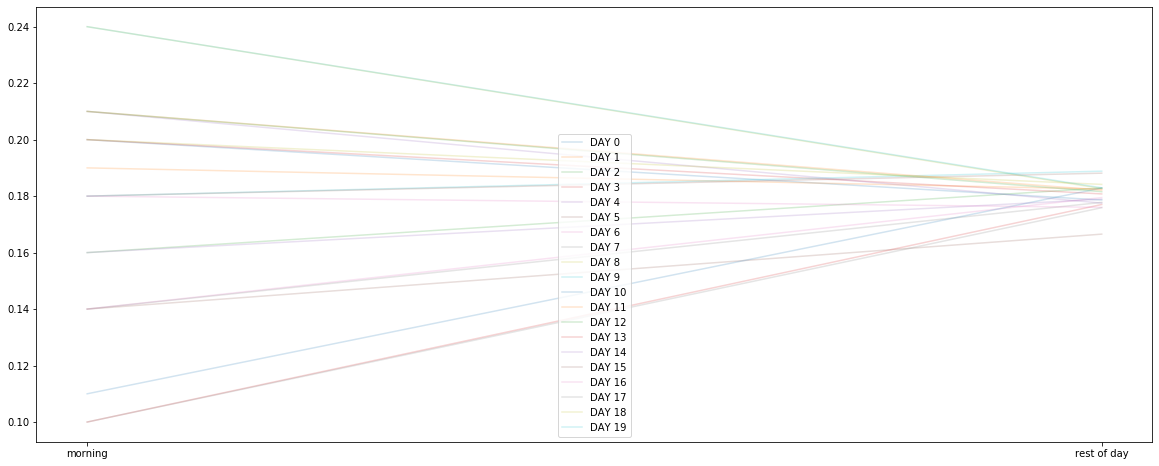

In [21]:
divider1 = 30
divider2 = 70
divider3 = 100
divider4 = 150
divider5 = 200
divider6 = 350
plt.figure(figsize=(20,8))

for i in range(20):
    X_morning  = full_data.loc[full_data.DAY == i].SUCCESS.iloc[:100].mean()
    X_rest = full_data.loc[full_data.DAY == i].SUCCESS.iloc[100:].mean()
    y = [X_morning, X_rest]
    x = ["morning", "rest of day"]
    plt.plot(x,y, alpha = 0.2, label="DAY %s"%i)


plt.legend()
plt.show()

We see that there is no real relationship for success in "morning" compared to rest of day over time

- However in general, success rate is higher in "morning" trades

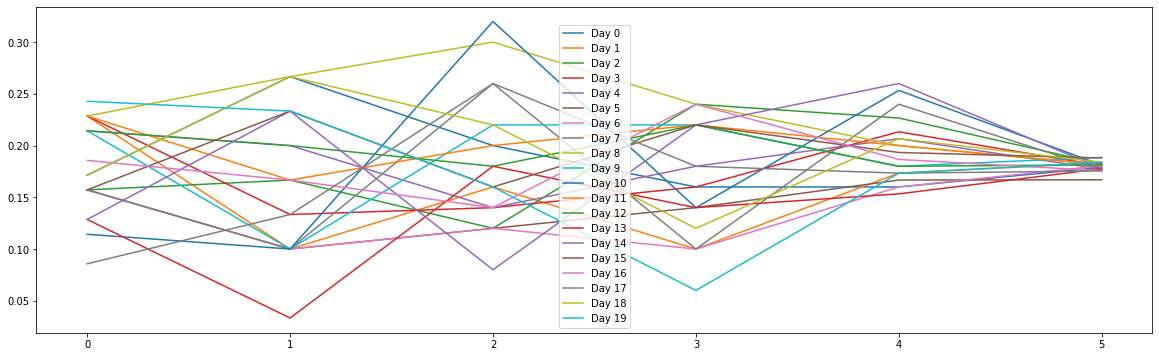

In [22]:
d2 = 70
d3 = 100
d4 = 150
d5 = 200
d6 = 350
plt.figure(figsize=(20,6))

for i in range(20):
    X1  = full_data.loc[full_data.DAY == i].SUCCESS.iloc[:d2].mean()
    X2 = full_data.loc[full_data.DAY == i].SUCCESS.iloc[d2:d3].mean()
    X3 = full_data.loc[full_data.DAY == i].SUCCESS.iloc[d3:d4].mean()
    X4 = full_data.loc[full_data.DAY == i].SUCCESS.iloc[d4:d5].mean()
    X5 = full_data.loc[full_data.DAY == i].SUCCESS.iloc[d5:d6].mean()
    X6 = full_data.loc[full_data.DAY == i].SUCCESS.iloc[d6:].mean()

    y = [X1,X2,X3,X4,X5,X6]
    
    plt.plot([i for i in range(len(y))],y, label= "Day %s"%i)
plt.legend()
plt.show()

- Success rate tends toward 17.6% each day
    - Some days Start of with Higher success and decrease
    - Some start lower and increase


### EDGE Analysis

#### Average Edge Over time

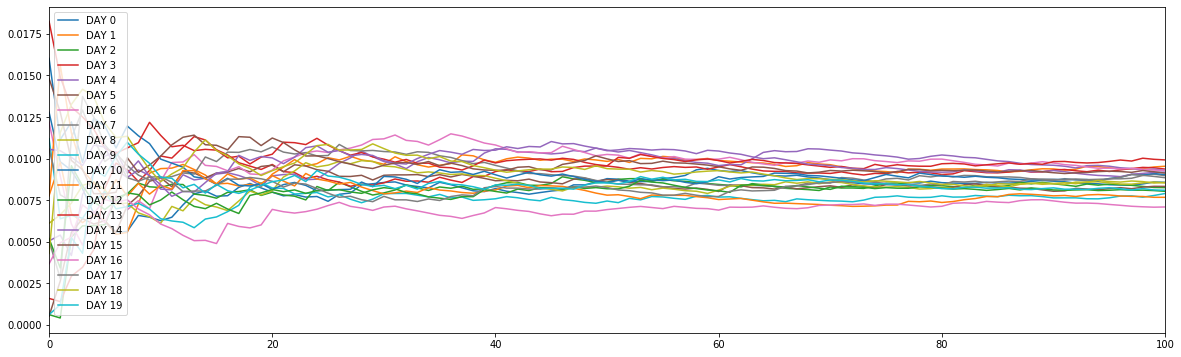

In [23]:
avg_edge_daily = []
avg_edge_overall = []
avg_edge_overall_comb = [] 
day = 0
plt.figure(figsize=(20,6))
for day in range(20):
    sum_edge = 0
    num = 1
    X = full_data.loc[full_data.DAY == day].EDGE
    for i in X:
        sum_edge += i
        curr_val = sum_edge / num
        avg_edge_daily.append(curr_val)
        num+=1

    avg_edge_overall.extend(avg_edge_daily)
    plt.plot(avg_edge_daily, label = "DAY %s"%day )
    #print("DAys average is %s:"%day,avg_edge_daily[-1])
    day += 1
    avg_edge_daily = []
plt.xlim(0,100)
plt.legend()
plt.show()


We see that the data is very noisy, but when averaged overall there is an expected trend:
- Trades at market open have a higher Edge, and then over time Edge per order decreeases and stabalises to an average value 
- This is as expected and is one of the things causes lower success rate at market open 

### Order volume and Latency

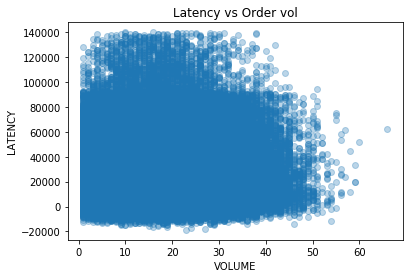

In [24]:
laten = full_data.LATENCY
vol = full_data.VOLUME
plt.scatter(vol, laten, alpha=0.3)
plt.title("Latency vs Order vol")
plt.xlabel("VOLUME")
plt.ylabel("LATENCY")
plt.show()

Latency and Order Volume have a slight relationship
- This is because Volume has a linear relationship to EDGE and Latency is related to EDGE (see below)

### Edge and Volume

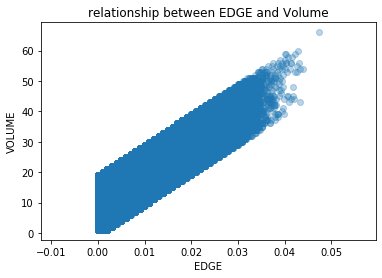

In [25]:
Edge = full_data.EDGE
vol = full_data.VOLUME
plt.scatter(Edge,vol, alpha= 0.3)
plt.title("relationship between EDGE and Volume")
plt.xlabel("EDGE")
plt.ylabel("VOLUME")
plt.show()


Edge and Volume for a given Day

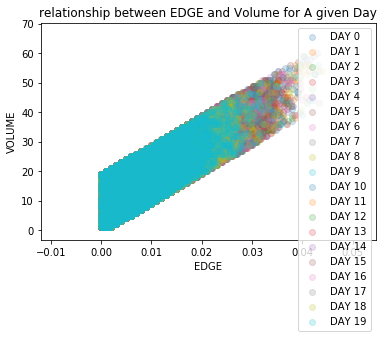

In [26]:
for i in range(20):
    Edge = full_data.loc[full_data.DAY == i].EDGE
    vol = full_data.loc[full_data.DAY == i].VOLUME
    plt.scatter(Edge,vol, label = "DAY %s"%i, alpha=0.2)


plt.title("relationship between EDGE and Volume for A given Day")
plt.xlabel("EDGE")
plt.ylabel("VOLUME")
plt.legend()
plt.show()

we see that EDGE and VOLUME has a positive linear relationship, which is expected - the higher the edge, the lower the risk of the trade, and the better the opportunity, so Traders are able to take higher positions

- This relationship is independent of Gateway used or DAY
- The Volume is a function of EDGE and Order type as has no affect on SUCCESS

There is a Band of volumes for each EDGE which could suggest that there are specific order types which are assigned a given volume  

#### Linear Regression on Edge and Volume

In [27]:
from sklearn import linear_model ## allows you to build the model
from sklearn.metrics import mean_squared_error, r2_score ## allows you to compute the performance
model = linear_model.LinearRegression()

from sklearn.model_selection import train_test_split
X = full_data[["EDGE","GW"]]
Y = full_data.VOLUME
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print('Coefficients:', model.coef_) # these are the b's / weights on each feature
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred))
print('Coefficient of determination (R^2): %.2f' #  %.2f means we show to 2 dp
      % r2_score(Y_test, Y_pred))

c:\Users\joshu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
c:\Users\joshu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-note

Coefficients: [9.87819784e+02 2.00540766e-02]
Intercept: 9.13196030186695
Mean squared error (MSE): 33.03
Coefficient of determination (R^2): 0.56


We see gradient is about Volume ~ 1000 * EDGE + intercept

Intercept varies from 0 to 20

We can Split the Orders into Order type based on the Volume intercept given to it


In [28]:
full_data["Order_type"] = np.where(full_data["VOLUME"] < 1000* full_data["EDGE"] + 5, 1,2)
full_data["Order_type"] = np.where(full_data["VOLUME"] > 1000* full_data["EDGE"] + 10, 3,full_data["Order_type"])
full_data["Order_type"] = np.where(full_data["VOLUME"] > 1000* full_data["EDGE"] + 15, 4,full_data["Order_type"])


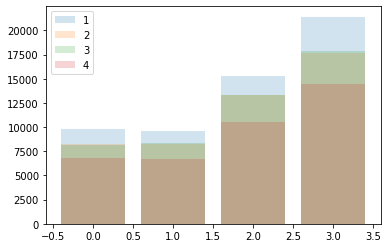

In [29]:
for i in range(1,5,1):
    X = full_data.loc[full_data.Order_type == i].GW.value_counts()
    plt.bar(X.index,X, alpha = 0.2, label=i)
plt.legend()
plt.show()

<BarContainer object of 4 artists>

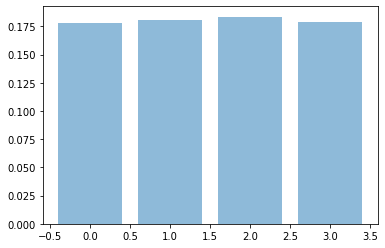

In [30]:
stack = []
for i in range(1,5,1):
    X = full_data.loc[full_data.Order_type == i].SUCCESS.mean()
    stack.append(X)
plt.bar([i for i in range(len(stack))],stack,alpha = 0.5)
# success rate is fixed

<BarContainer object of 4 artists>

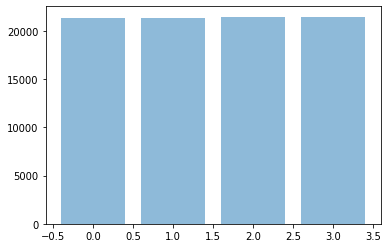

In [31]:
stack = []
for i in range(1,5,1):
    X = full_data.loc[full_data.Order_type == i].LATENCY.median()
    stack.append(X)
plt.bar([i for i in range(len(stack))],stack,alpha = 0.5)

The LATENCY, and SUCCESS is not impacted by the Volume given to an order of a specific EDGE 

## Edge and Latency

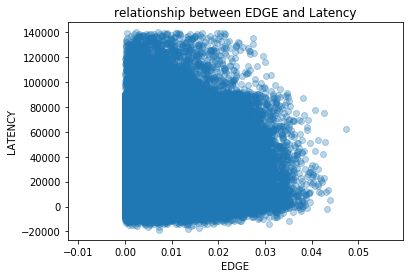

In [32]:
Edge = full_data.EDGE
vol = full_data.LATENCY
plt.scatter(Edge,vol, alpha=0.3)
plt.title("relationship between EDGE and Latency")
plt.xlabel("EDGE")
plt.ylabel("LATENCY")
plt.show()


Edge and Latency for each gateway

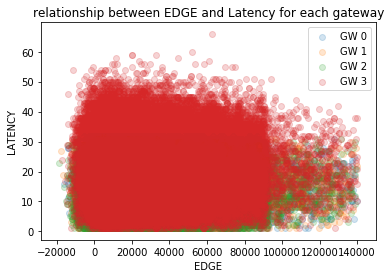

In [33]:
for i in range(4):
    Edge = full_data.loc[full_data.GW == i].LATENCY
    vol = full_data.loc[full_data.GW == i].VOLUME
    plt.scatter(Edge,vol, label = "GW %s"%i, alpha=0.2)


plt.title("relationship between EDGE and Latency for each gateway")
plt.xlabel("EDGE")
plt.ylabel("LATENCY")
plt.legend()
plt.show()

Ultimately Traders will aim to minimize latency for all trades, but we see that as Edge increases, latency Decreases. Reasonign could be:
-  higher edge opportunities are less risky so require less decision making time
- High edge opportunites require lower latency for success


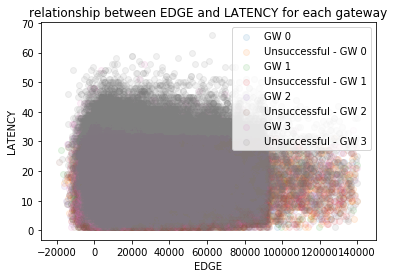

In [34]:
for i in range(4):
    Edge = full_data.loc[(full_data.GW == i) & (full_data.SUCCESS == 1)].LATENCY
    vol = full_data.loc[(full_data.GW == i) & (full_data.SUCCESS == 1)].VOLUME
    plt.scatter(Edge,vol, label = "GW %s"%i, alpha=0.1)
    Edge = full_data.loc[(full_data.GW == i) & (full_data.SUCCESS == 0)].LATENCY
    vol = full_data.loc[(full_data.GW == i) & (full_data.SUCCESS == 0)].VOLUME
    plt.scatter(Edge,vol, label = "Unsuccessful - GW %s"%i, alpha=0.1)


plt.title("relationship between EDGE and LATENCY for each gateway")
plt.xlabel("EDGE")
plt.ylabel("LATENCY")
plt.legend()
plt.show()

### Latency vs EDGE and EDGE_EURO

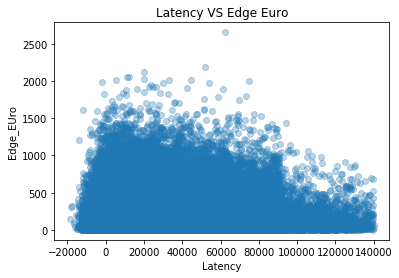

In [35]:

laten = full_data.LATENCY
edge_eu = full_data.EDGE_EUR
plt.scatter(laten, edge_eu, alpha=0.3)
plt.title("Latency VS Edge Euro")
plt.xlabel("Latency")
plt.ylabel("Edge_EUro")
plt.show()


We see a positively skewed distributiothn - the higher the latency, the lower the EDGE_EURO

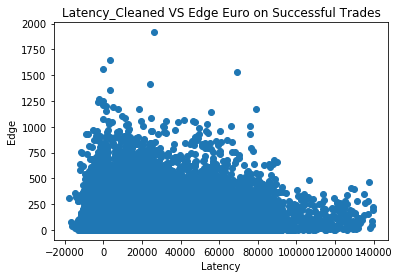

In [36]:
laten = full_data.loc[full_data.SUCCESS == 1].LATENCY
edge_eu = full_data.loc[full_data.SUCCESS == 1].EDGE_EUR
plt.scatter(laten, edge_eu)

plt.title("Latency_Cleaned VS Edge Euro on Successful Trades")
plt.xlabel("Latency")
plt.ylabel("Edge")
plt.show()


EDGE vs Latency

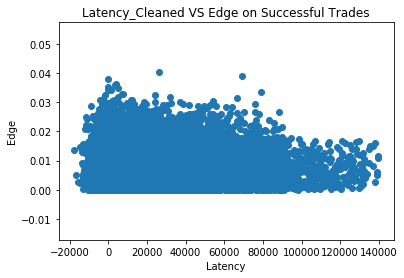

In [37]:
laten = full_data.loc[full_data.SUCCESS == 1].LATENCY
edge_eu = full_data.loc[full_data.SUCCESS == 1].EDGE
plt.scatter(laten, edge_eu)

plt.title("Latency_Cleaned VS Edge on Successful Trades")
plt.xlabel("Latency")
plt.ylabel("Edge")
plt.show()


Much more positvely skewed for succesful trades, showing high EDGE Trades requrie lower latency

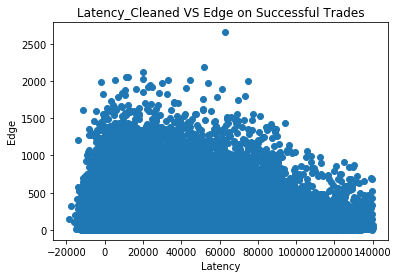

In [38]:
laten0 = full_data.loc[full_data.SUCCESS == 0].LATENCY
edge0 = full_data.loc[full_data.SUCCESS == 0].EDGE_EUR
plt.scatter(laten0, edge0)

plt.title("Latency_Cleaned VS Edge on Successful Trades")
plt.xlabel("Latency")
plt.ylabel("Edge")
plt.show()

### Success Rate and Latency

Overall SUCCESS on an Order is binary; order is successful if it reaches exchange first (without considering price)
- Therefore a given order will fail unless the latency is below a specific cutt-off value (lower than current lowest)
- So if we vary latency we should reach a value where success rate drops 
    - This will mark the latency we must have on our orders for us to effectively increase chance of success


We also see that for higher edge opportunities, Latency has a higher affect on Success rate compared to lower edge opportunites
- As edge increases, the opportunity is more noticeable so is in higher demand
- Orders that are successful with High latency are succesful because it may be non-competitibe opportunity, or because it was not noticed 

Other reasons why High Latency Orders can be successful includes:
- Better Prices are offered to the exchange.
    - Most order books use price-time priority to decide which orders get executed first, so pricing is a factor in success
         

## Gate Usage

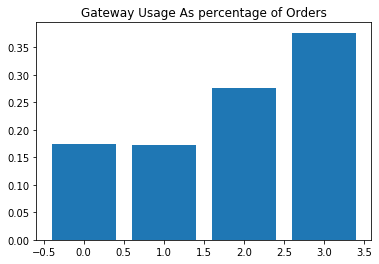

3    0.376574
2    0.276019
0    0.174499
1    0.172908
Name: GW, dtype: float64


In [39]:
X = full_data.GW.value_counts() / len(full_data)
y = [i for i in range(len(X))]
plt.bar(X.index,X)
plt.title("Gateway Usage As percentage of Orders")
plt.show()
print(X)

We see Gates 0 and 1 are least used and gate 3 is most used gateway to exchange

In [40]:

for i in range(4):
    print("Max EDGE orders through Gateway %s is:"%i, round(full_data.loc[full_data.GW == i].EDGE.max(),5))

print("\n EDGE_EURO \n")

for i in range(4):
    print("Max EDGE_EURO orders through Gateway %s is:"%i, round(full_data.loc[full_data.GW == i].EDGE_EUR.max(),5))




Max EDGE orders through Gateway 0 is: 0.01383
Max EDGE orders through Gateway 1 is: 0.01383
Max EDGE orders through Gateway 2 is: 0.01383
Max EDGE orders through Gateway 3 is: 0.0473

 EDGE_EURO 

Max EDGE_EURO orders through Gateway 0 is: 375.97221
Max EDGE_EURO orders through Gateway 1 is: 375.71253
Max EDGE_EURO orders through Gateway 2 is: 375.65333
Max EDGE_EURO orders through Gateway 3 is: 2653.66173


Average Volume Per Gateway

Text(0.5, 1.0, 'gateways and average order volume')

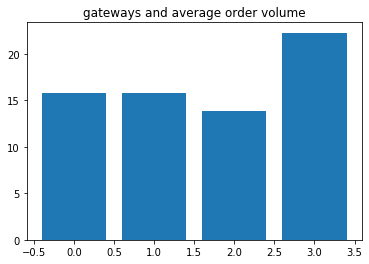

In [41]:
gateway = full_data.groupby("GW").apply(lambda x: x.VOLUME.mean())
plt.bar(gateway.index, gateway)
plt.title("gateways and average order volume")

Average Edge on each Gate

GW
0    0.006723
1    0.006732
2    0.004782
3    0.013245
dtype: float64


Text(0.5, 1.0, 'gateways and average EDGE')

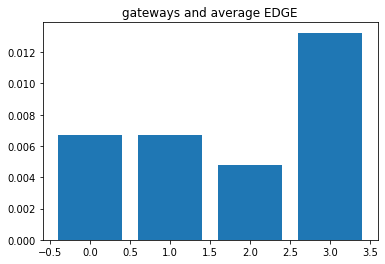

In [42]:
gateway = full_data.groupby("GW").apply(lambda x: x.EDGE.mean())
print(gateway)
plt.bar(gateway.index, gateway)
plt.title("gateways and average EDGE")

Average EDGE_EUR on each gateway

GW
0    100.811017
1    101.468860
2     68.897985
3    295.612370
dtype: float64


Text(0.5, 1.0, 'gateways and average EDGE_EURO')

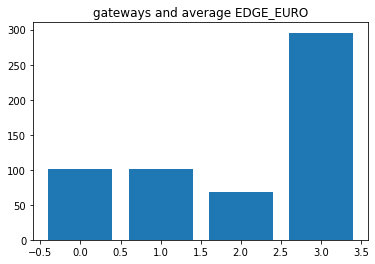

In [43]:
gateway = full_data.groupby("GW").apply(lambda x: x.EDGE_EUR.mean())
print(gateway)
plt.bar(gateway.index, gateway)
plt.title("gateways and average EDGE_EURO")

Gates 0, 1 and 2 are only used on Low Edge opportunities, which are valued at 0.01383 or less.

Gate 3 is used for all different opportunites
- This is why Gate 3 is used more often and has a higher average EDGE and EDGE_EUR
- Additionally, as EDGE increases success rate decreases which is why Gate 3 has a lower Success rate


###  Average EDGE per day for a given gate

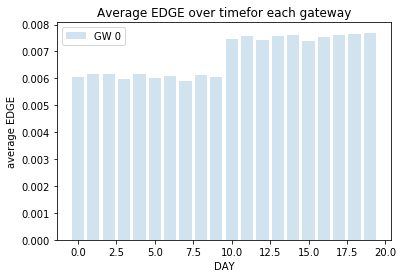

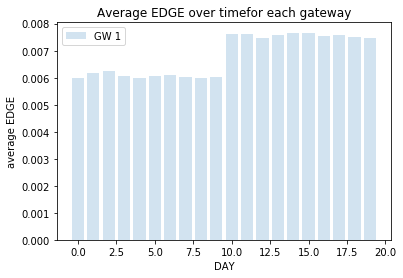

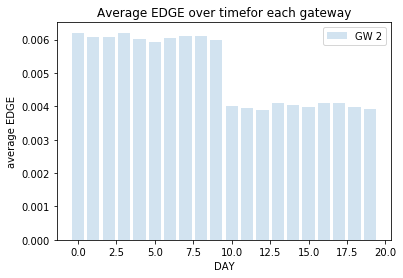

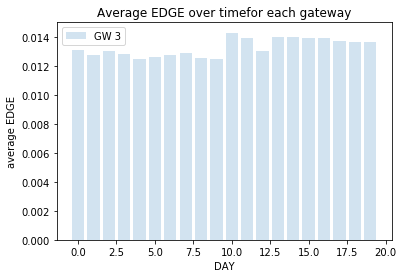

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np


full_data = pd.read_csv("execution_research_assignment_data.csv")
edge = []
for i in range(4):
    edge = []
    for j in range(20):
        edge.append(full_data.loc[(full_data.GW == i) & (full_data.DAY == j)].EDGE.mean())
        #vol = full_data.loc[(full_data.GW == i) & (full_data.DAY == j)].VOLUME
    plt.bar([i for i in range(20)],edge, label = "GW %s"%i, alpha=0.2)


    plt.title("Average EDGE over timefor each gateway")
    plt.xlabel("DAY")
    plt.ylabel("average EDGE")
    plt.legend()
    plt.show()

- Gate 0 and  1's average EDGE is at 0.006 for the first 10 days, on DAY 10, there is a spike in Average_EDGE 
- opposite is true for Gateway 2 which starts high 0.006 and drops down to 0.004 at day 10
- Gate 3 is mostly consistently with  aslight spike in EDGE on day 10

This may occur because of a switch in Strategy, or because there is a change in the Gateways characteristics


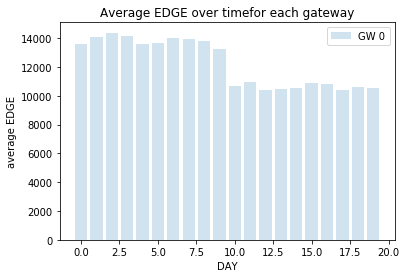

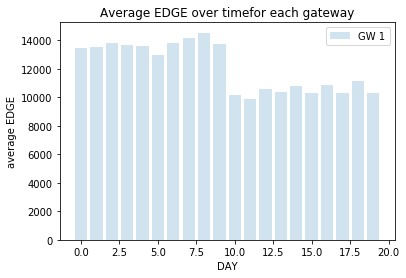

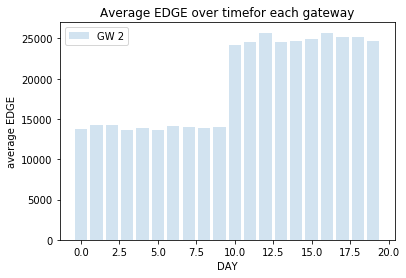

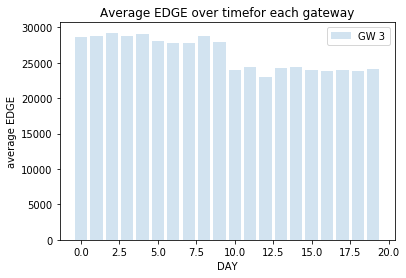

In [45]:
edge = []
for i in range(4):
    edge = []
    for j in range(20):
        edge.append(full_data.loc[(full_data.GW == i) & (full_data.DAY == j)].count().sum())
        #vol = full_data.loc[(full_data.GW == i) & (full_data.DAY == j)].VOLUME
    plt.bar([i for i in range(20)],edge, label = "GW %s"%i, alpha=0.2)


    plt.title("Average EDGE over timefor each gateway")
    plt.xlabel("DAY")
    plt.ylabel("average EDGE")
    plt.legend()
    plt.show()

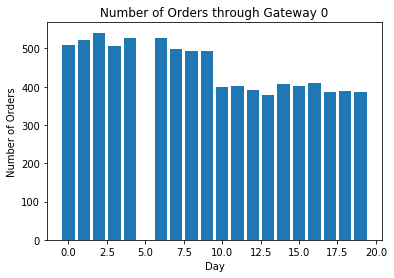

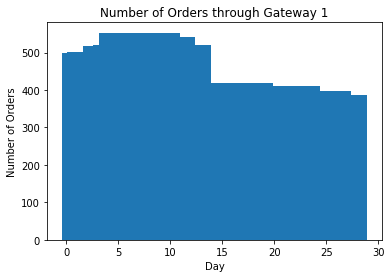

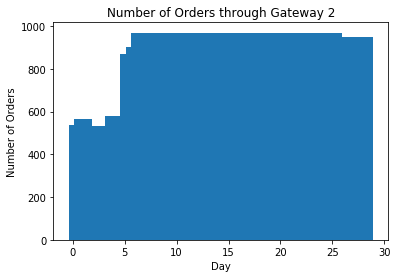

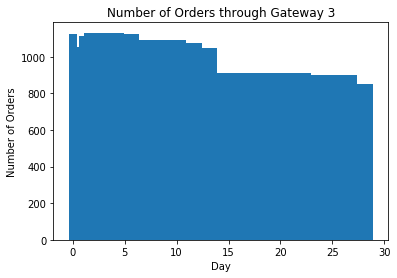

In [47]:
import pandas as pd
import matplotlib.pyplot as plt


df = full_data.copy()

# Group by 'DAY' and 'GW' and count the number of orders
edge = df.LATENCY.quantile(0.25)
order_counts = df.loc[df.LATENCY <edge].groupby(['DAY', 'GW']).size().reset_index(name='OrderCount')

# Get unique gateways
gateways = order_counts['GW'].unique()

# Plotting each gateway separately
for gateway in gateways:
    gateway_data = order_counts[order_counts['GW'] == gateway]
    plt.figure(figsize=(6, 4))
    plt.bar(gateway_data['DAY'], gateway_data['OrderCount'])
    plt.title(f'Number of Orders through Gateway {gateway}')
    plt.xlabel('Day')
    plt.ylabel('Number of Orders')
    plt.show()


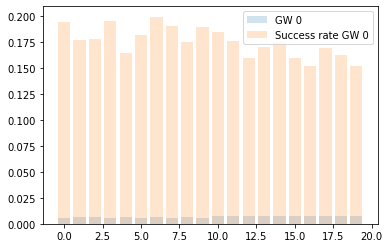

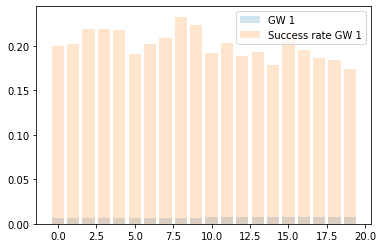

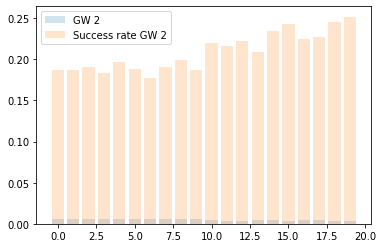

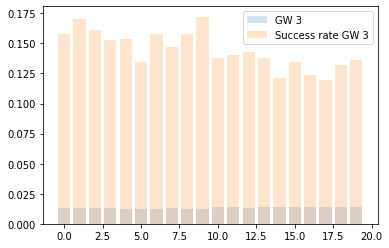

In [48]:
edge = []
suc = []
for i in range(4):
    edge = []
    succ = []
    for j in range(20):
        edge.append(full_data.loc[(full_data.GW == i) & (full_data.DAY == j)].EDGE.mean())
        #vol = full_data.loc[(full_data.GW == i) & (full_data.DAY == j)].VOLUME
    for j in range(20):
        succ.append(full_data.loc[(full_data.GW == i) & (full_data.DAY == j)].SUCCESS.mean())
    plt.bar([i for i in range(20)],edge, label = "GW %s"%i, alpha=0.2)
    #plt.bar([i for i in range(20)],edge, label = "Success rate GW %s"%i, alpha=0.2)



    plt.bar([i for i in range(20)],succ, label = "Success rate GW %s"%i, alpha=0.2)
    plt.legend()
    plt.show()

Success rate Follows the same pattern as EDGE

### Success of Order through each gate

SUCCESS      0      1         %
GW                             
0        28789   6168  0.176445
1        27542   7006  0.202790
2        43603  11925  0.214757
3        64050  10917  0.145624


Text(0.5, 1.0, 'Gateways % of success')

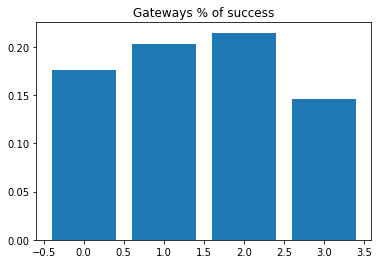

In [49]:
gateway = full_data.groupby("GW").apply(lambda x: x.SUCCESS.value_counts())
new_data = (gateway.iloc[:,1]) / ((gateway.iloc[:,1])+ (gateway.iloc[:,0]))
gateway.insert(2, "%", new_data,True)
print(gateway)
X = gateway.iloc[:,2]
plt.bar(gateway.index, X)
plt.title("Gateways % of success")

### Success rate of Gateways for value of Edge

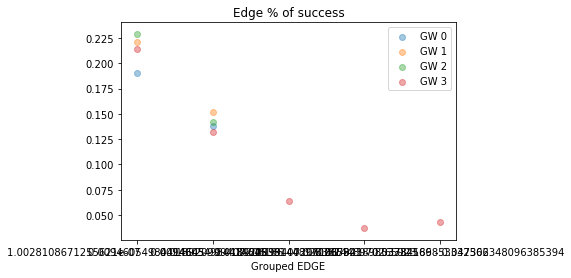

In [50]:

edge_euro_range = full_data.EDGE.max() - full_data.EDGE.min()
num_points = 5
bucket_size = edge_euro_range / num_points
#print(bucket_size)
buckets = [full_data.EDGE.min() + i*bucket_size for i in range(num_points+1)]


label  = ["{}".format(buckets[i]) + " - " + "{}".format(buckets[i+1])  for i in range(len(buckets) - 1)]
split_edge_euro = pd.cut(full_data.EDGE, bins = buckets, include_lowest= True, labels=label)
#print("\n CHECK \n",split_edge_euro.value_counts())

X = full_data.copy()
X["Split_Edge"] = split_edge_euro
#print(X.head())



#gateway_edge = X.groupby(["GW", "Split_Edge"]).apply(lambda x: x.SUCCESS.value_counts())

#print(gateway_edge.index)#.iloc[0])
for i in range(4):
    edge_euro_split_success = X.loc[(X.SUCCESS == 1) & (X.GW == i)].groupby("Split_Edge").SUCCESS.count() 
    edge_euro_split_fail = X.loc[(X.SUCCESS == 0) & (X.GW == i)].groupby("Split_Edge").SUCCESS.count() 
    new_data = edge_euro_split_success / (edge_euro_split_fail + edge_euro_split_success)
    #print(new_data)
    x = new_data
    plt.scatter(edge_euro_split_success.index, x , label = "GW {}".format(i), alpha= 0.4)
plt.legend()
plt.title("Edge % of success")
plt.xlabel("Grouped EDGE")
plt.show()

- We see that Gate 0 and 3 are less successful on Average compared to GWs 1 and 2 overall
- We see that Gate 2 is the most successfull overall



## Latency Over Time

## Latency and Success

Density Plot of Success and Latency

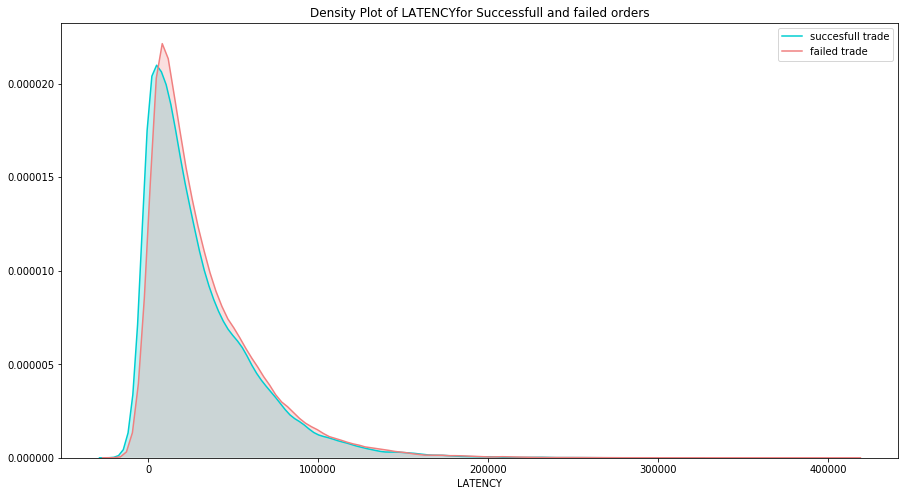

In [51]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(full_data["LATENCY"][full_data.SUCCESS == 1], color="darkturquoise", shade=True)
sns.kdeplot(full_data["LATENCY"][full_data.SUCCESS== 0], color="lightcoral", shade=True)
plt.legend(['succesfull trade', 'failed trade'])
plt.title('Density Plot of LATENCYfor Successfull and failed orders')
ax.set(xlabel='LATENCY')
#plt.xlim(-100,300)
plt.show()

### By Splitting Latency Into Intervals We can see A Pattern

Text(0.5, 1.0, 'Latency speed % of success')

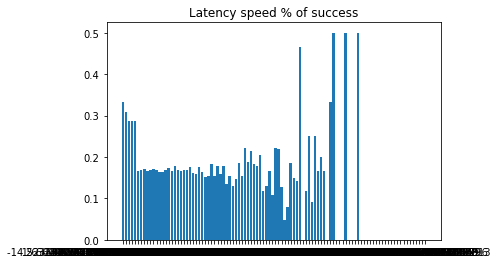

In [52]:
# Split latency into groups
latency_range = (full_data.LATENCY.max() - full_data.LATENCY.min()) * 10**(-3)
num_points = 100
bucket_size = latency_range / num_points
buckets = [(full_data.LATENCY.min() ) * 10**(-3)+ i*bucket_size for i in range(num_points+1)]
label  = ["{}".format(buckets[i]) + " - " + "{}".format(buckets[i+1])  for i in range(len(buckets) - 1)]
L = full_data.LATENCY * (0.001)
split_latency = pd.cut(L, bins = buckets, include_lowest= True, labels=label)
X = full_data.copy()
X["Split_Latency_micro"] = split_latency
Z = X.groupby("Split_Latency_micro").SUCCESS.mean() 
#print(Z.head(15))
x = new_data
plt.bar(Z.index, Z)
plt.title("Latency speed % of success")

- Trades with latency less that 
Success of an Order is binary (when not considering other factors ) and depend on speed and competition
- For trades, if you are first, trades execute (if your latency is below a cut-off)
    - We can see that the cut-off is 2.7micro seconds

Success on Higher latency trades only occur if there are opportunites others do not see quickly or others do not notice
- Edge can be subjective, it is a value we put on the trade
- High Latency Trades will have a high success rate be

### Latency and Success Each day

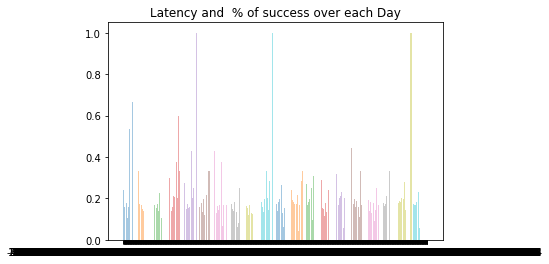

In [53]:
# Split latency into groups

for i in range(20):
    L = full_data.loc[full_data.DAY == i].LATENCY * (0.001) # convert to micro seconds
    latency_range = (L.max() - L.min()) 
    num_points = 70
    bucket_size = latency_range / num_points
    buckets = [(L.min() ) + i*bucket_size for i in range(num_points+1)]
    label  = ["{}".format(buckets[i]) + " - " + "{}".format(buckets[i+1])  for i in range(len(buckets) - 1)]
    split_latency = pd.cut(L, bins = buckets, include_lowest= True, labels=label)

    X = full_data.copy()
    X["Split_Latency_micro"] = split_latency
    Z = X.groupby("Split_Latency_micro").SUCCESS.mean() 
    #print("\n Day %s \n"%i)
    #print(Z.head(10))
    plt.bar(Z.index, Z, label = "DAY is: %s"%i, alpha =0.4 )
    plt.title("Latency and  % of success over each Day")
#plt.legend()
plt.show()

We see that each day, very high latency trades have the highest success rates - this is because higher latency trades are on opportunities competitors do not notice, or require analysis to determine what order to send
Non-obvious trades will have less competition


Tends to be a sharp drop off in success rate at 2.5-2.8 micro seconds

Success on High Latency (non-obivous opportunities) Increases over the 20 days

### How success varies on Low Latency Trades over time

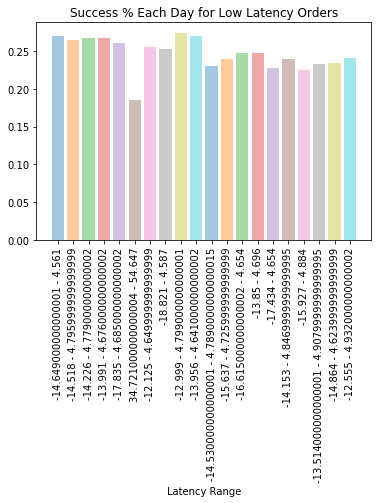

In [54]:
# Split latency into groups
# Define low latency
low = 0.15 # bottom 10% of latency
edge_level = 0.9

for i in range(20):
    x_latency = full_data.loc[full_data.DAY==i].LATENCY.quantile(low)
    L = full_data.loc[(full_data.DAY == i) & (full_data.LATENCY < x_latency)].LATENCY * (0.001) # convert to micro seconds
    latency_range = (L.max() - L.min()) 
    num_points = 1
    bucket_size = latency_range / num_points
    buckets = [(L.min() ) + i*bucket_size for i in range(num_points+1)]
    #print(x)
    label  = ["{}".format(buckets[i]) + " - " + "{}".format(buckets[i+1])  for i in range(len(buckets) - 1)]
    split_latency = pd.cut(L, bins = buckets, include_lowest= True, labels=label)

    X = full_data.copy()
    X["Split_Latency_micro"] = split_latency
    Z = X.groupby("Split_Latency_micro").SUCCESS.mean() 
    #print("\n Day %s \n"%i)
    #print(Z.head(10))
    plt.bar(Z.index, Z, label = "DAY is: %s"%i, alpha =0.4 )
    plt.title("Success % Each Day for Low Latency Orders")

    plt.xticks([i for i in range(20)], rotation = 90)
plt.xlabel("Latency Range")
#plt.legend()
plt.show()

### Seeing How Success Varies for Different Latencies and EDGEs

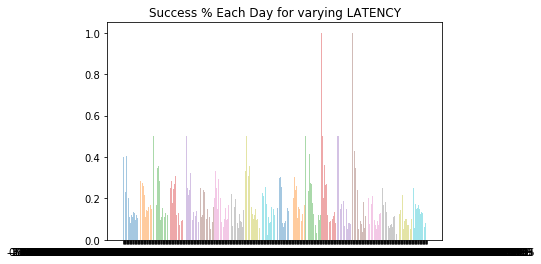

In [55]:
# Split latency into groups
# Define low latency
low = 0.5 # bottom 10% of latency
edge_level = 0.7

for i in range(20):
    x_latency = full_data.loc[full_data.DAY==i].LATENCY.quantile(low)
    x_edge = full_data.loc[full_data.DAY==i].EDGE.quantile(edge_level)
    L = full_data.loc[(full_data.DAY == i) & (full_data.LATENCY < x_latency) & (full_data.EDGE > x_edge)].LATENCY * (0.001) # convert to micro seconds
    latency_range = (L.max() - L.min()) 
    num_points = 25
    bucket_size = latency_range / num_points
    buckets = [(L.min() ) + i*bucket_size for i in range(num_points+1)]
    #print(x)
    label  = ["{}".format(buckets[i]) + " - " + "{}".format(buckets[i+1])  for i in range(len(buckets) - 1)]
    split_latency = pd.cut(L, bins = buckets, include_lowest= True, labels=label)

    X = full_data.copy()
    X["Split_Latency_micro"] = split_latency
    Z = X.groupby("Split_Latency_micro").SUCCESS.mean() 
    #print("\n Day %s \n"%i)
    #print(Z.head(10))
    plt.bar(Z.index, Z, label = "DAY is: %s"%i, alpha =0.4 )
    plt.title("Success % Each Day for varying LATENCY")
#plt.legend()
plt.show()

How Success rate changes for Low Latency Trades as Edge changes

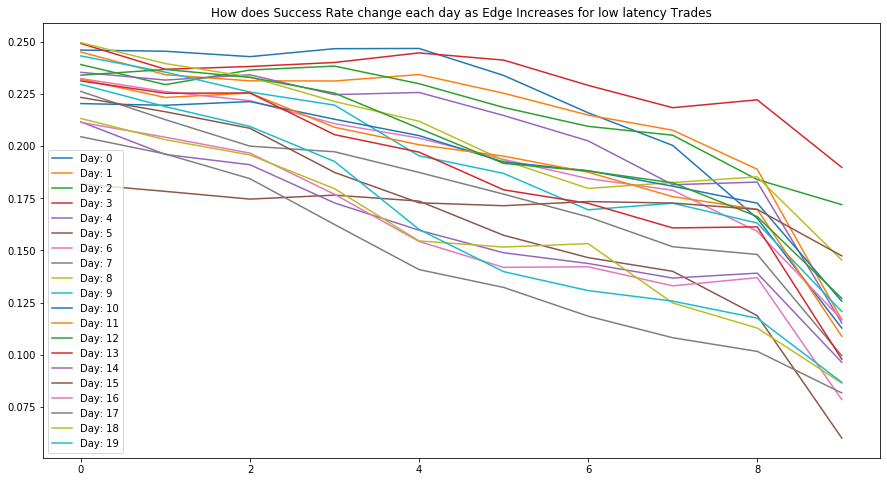

In [56]:
# Split latency into groups
# Define low latency
low = 0.2 # bottom 10% of latency
edge_level_stack = [0.1*i for i in range(10)]
succ_stack = []
plt.figure(figsize=(15,8))

for edge_level in edge_level_stack:
    temp = []
    for i in range(20):
        
        x_latency = full_data.loc[full_data.DAY==i].LATENCY.quantile(low)
        x_edge = full_data.loc[full_data.DAY==i].EDGE.quantile(edge_level)
        L = full_data.loc[(full_data.DAY == i) & (full_data.LATENCY < x_latency) & (full_data.EDGE > x_edge)].LATENCY * (0.001) # convert to micro seconds
        latency_range = (L.max() - L.min()) 
        num_points = 1
        bucket_size = latency_range / num_points
        buckets = [(L.min() ) + i*bucket_size for i in range(num_points+1)]
        #print(x)
        label  = ["{}".format(buckets[i]) + " - " + "{}".format(buckets[i+1])  for i in range(len(buckets) - 1)]
        split_latency = pd.cut(L, bins = buckets, include_lowest= True, labels=label)

        X = full_data.copy()
        X["Split_Latency_micro"] = split_latency
        Z = X.groupby("Split_Latency_micro").SUCCESS.mean()
        temp.append(Z.iloc[0])
        #print("\n Day %s \n"%i)
        #print(Z.head(10))
        #plt.bar(Z.index, Z, label = "DAY is: %s"%i, alpha =0.4 )
        #plt.title("Latency speed % of success")
    succ_stack.append(temp) 
#plt.legend()
    #plt.show()

for day in range(20):
    day_stack = []
    for j in range(10):
        day_stack.append(succ_stack[j][day])
    
    plt.plot(day_stack, label= "Day: %s"%day)
plt.legend()
plt.title("How does Success Rate change each day as Edge Increases for low latency Trades")
plt.show()


In General All Curves Show that as EDGE increases, success rate increases
- However there is a decreases in Success rates over time
- Success on High Edge Orders also Decreases over time

Data Is indicating that performance is worsening

### Finding The Latency That is Required for Success

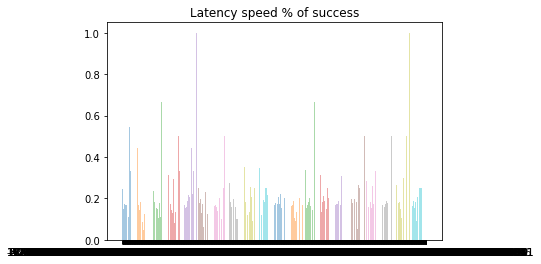

In [57]:
# Split latency into groups
# Define low latency
low = 1 # bottom 10% of latency
edge_level = 0.8

for i in range(20):
    x_latency = full_data.loc[full_data.DAY==i].LATENCY.quantile(low)
    L = full_data.loc[(full_data.DAY == i) & (full_data.LATENCY < x_latency)].LATENCY * (0.001) # convert to micro seconds
    latency_range = (L.max() - L.min()) 
    num_points = 100
    bucket_size = latency_range / num_points
    buckets = [(L.min() ) + i*bucket_size for i in range(num_points+1)]
    #print(x)
    label  = ["{}".format(buckets[i]) + " - " + "{}".format(buckets[i+1])  for i in range(len(buckets) - 1)]
    split_latency = pd.cut(L, bins = buckets, include_lowest= True, labels=label)

    X = full_data.copy()
    X["Split_Latency_micro"] = split_latency
    Z = X.groupby("Split_Latency_micro").SUCCESS.mean() 
    #print("\n Day %s \n"%i)
    #print(Z.head(10))
    plt.bar(Z.index, Z, label = "DAY is: %s"%i, alpha =0.4 )
    plt.title("Latency speed % of success")
#plt.legend()
plt.show()

Overall Success rate for Latency

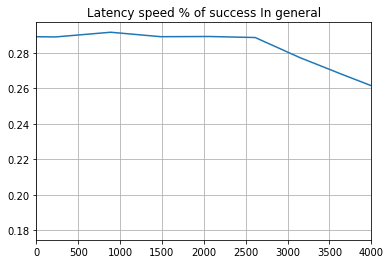

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
full_data = pd.read_csv("execution_research_assignment_data.csv")
# Split latency into groups
# Define low latency
low = 1 # bottom 10% of latency
edge_level_stack = [0.1*i for i in range(10)]
succ_stack = []
z = 0.01
latency_stack = [z*i for i in range(int(1/z))]
x_vals = []

edge_level = 0
for latency_val in latency_stack:
    x_edge = full_data.EDGE.quantile(edge_level)
    x_latency = full_data.loc[full_data.EDGE > x_edge].LATENCY.quantile(latency_val)
    L = full_data.loc[ (full_data.LATENCY < x_latency) & (full_data.EDGE > x_edge)] # convert to micro seconds
    succ_stack.append(L.SUCCESS.mean())
    x_vals.append(x_latency)

plt.plot(x_vals,succ_stack)
plt.title("Latency speed % of success In general")

#plt.legend()
plt.xlim(0,4000)
plt.grid()
plt.show()

We see success rate begin to decrease at around 2600 nano seconds

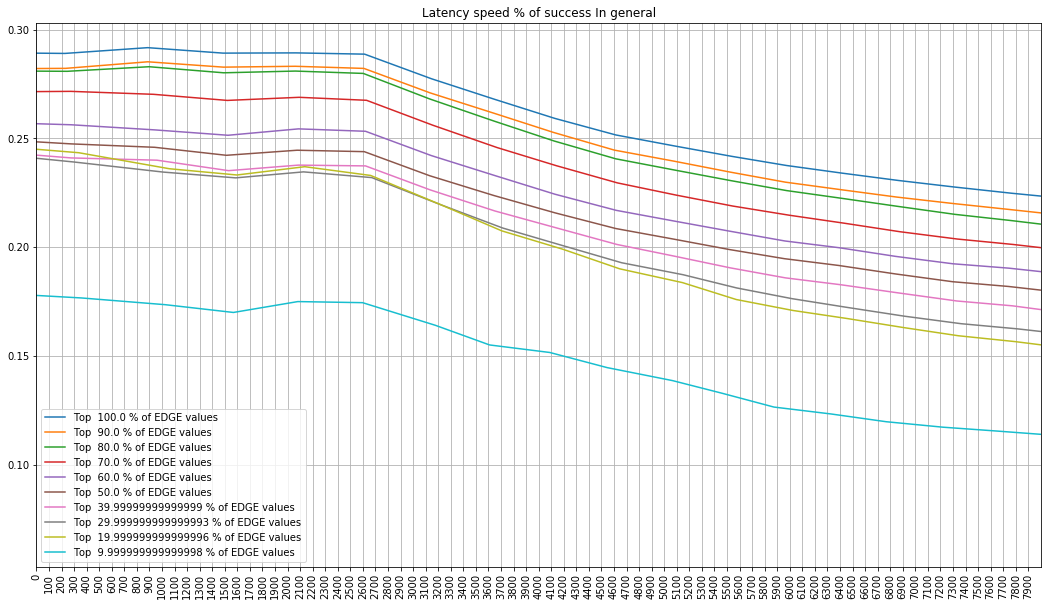

In [59]:
# Split latency into groups
# Define low latency
low = 1 # bottom 10% of latency
edge_level_stack = [0.1*i for i in range(10)]
succ_stack = []
z = 0.01
latency_stack = [z*i for i in range(int(1/z))]
x_vals = []
plt.figure(figsize=(18,10))
for edge_level in edge_level_stack:
    x_vals = []
    succ_stack = []

    for latency_val in latency_stack:
        x_edge = full_data.EDGE.quantile(edge_level)
        x_latency = full_data.loc[full_data.EDGE > x_edge].LATENCY.quantile(latency_val)
        L = full_data.loc[ (full_data.LATENCY < x_latency) & (full_data.EDGE > x_edge)] # convert to micro seconds
        succ_stack.append(L.SUCCESS.mean())
        x_vals.append(x_latency)

    plt.plot(x_vals,succ_stack, label="Top  {} % of EDGE values".format((1-edge_level)*100))
    plt.title("Latency speed % of success In general")

    plt.legend()
    plt.xlim(0,8000)
plt.xticks([i for i in range(0,8000,100)], rotation = 90)
plt.grid()
plt.show()

As mentioned previously, Success will depend if order reaches exchange first, so we should expect to see a Latency value, that below which success rate drops as we are below the cutt-off speed to be successful

- The data confirms this. We see that at 2.6 micro seconds the success rate drops
    - This shows the firm needs to aim for a latency of this and llwer
We also see that this is the case regardless of edge level

### How Success Rate For each latency changes for a given gate

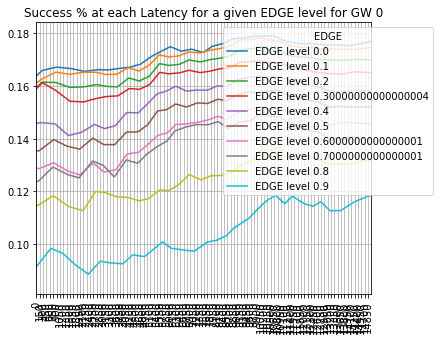

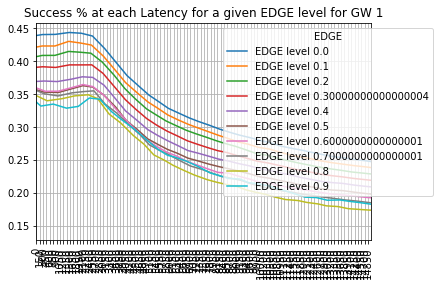

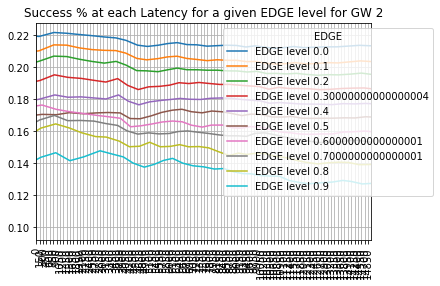

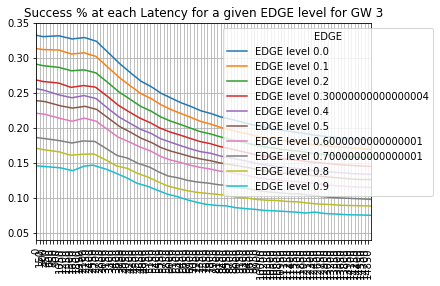

In [60]:
# Split latency into groups
# Define low latency
low = 1 # bottom 10% of latency
edge_level_stack = [0.1*i for i in range(10)]
succ_stack = []
z = 0.01
latency_stack = [z*i for i in range(int(1/z))]
x_vals = []
plt.figure(figsize=(6,5))
for i in range(4):
    for edge_level in edge_level_stack:
        x_vals = []
        succ_stack = []

        for latency_val in latency_stack:
            x_edge = full_data.loc[full_data.GW == i].EDGE.quantile(edge_level)
            x_latency = full_data.loc[(full_data.EDGE > x_edge ) & (full_data.GW == i)].LATENCY.quantile(latency_val)
            L = full_data.loc[ (full_data.LATENCY < x_latency) & (full_data.EDGE > x_edge)& (full_data.GW == i)] # convert to micro seconds
            succ_stack.append(L.SUCCESS.mean())
            x_vals.append(x_latency)

        plt.plot(x_vals,succ_stack, label="EDGE level {}".format(edge_level))
    #plt.figure(figsize=(18,10))
    plt.title("Success % at each Latency for a given EDGE level for GW {}".format(i))
    plt.legend(title='EDGE', loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.xlim(0,15000)
    plt.xticks([i for i in range(0,15000,150)], rotation = 90)
    plt.grid()
    plt.show()

GW performance does clearly vary
- We see that GW 1 performs the best on low latency Orders giving Success rates of almost 45% on Low Edge Trades with low latency
- GW 3 also performs well 
- Both GW 1 and 3 show that they are responsive to our Latency, indicating that they are the fastest GWs
- GW 0 and 2 give a less varying success probability as latency decreases, indicating they are better for lower latency Orders
    - GW2 overall has a higher Success rate thna GW0
- 

#### How does this vary Over time?

DAY =  0


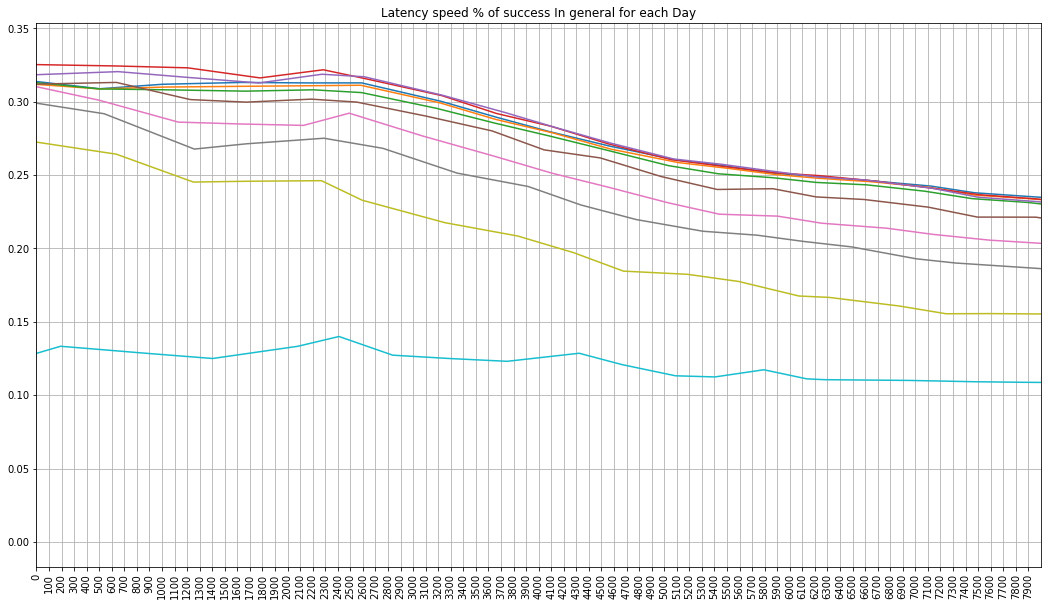

DAY =  1


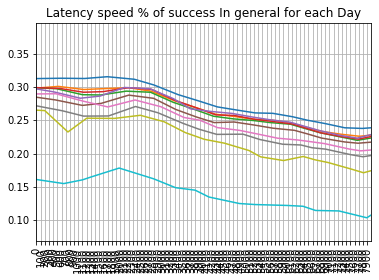

DAY =  2


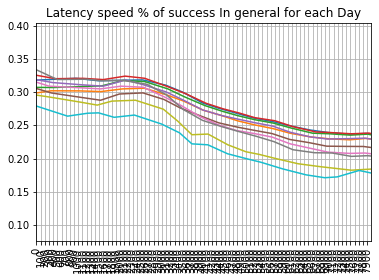

DAY =  3


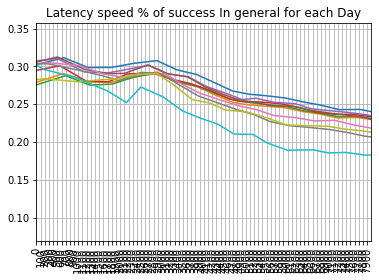

DAY =  4


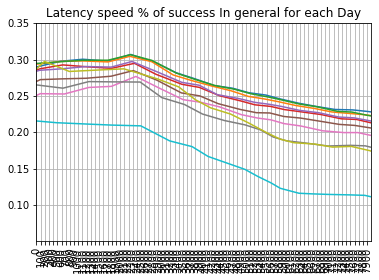

DAY =  5


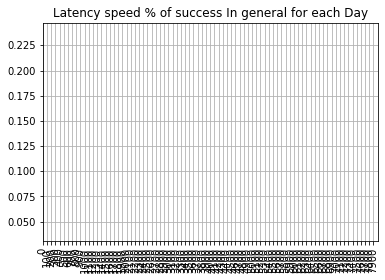

DAY =  6


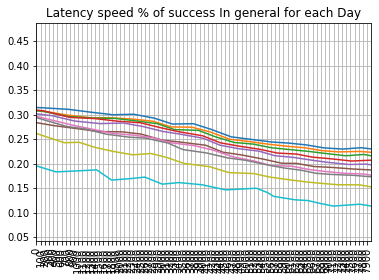

DAY =  7


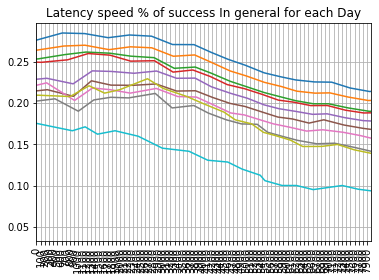

DAY =  8


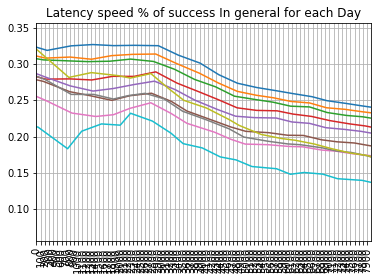

DAY =  9


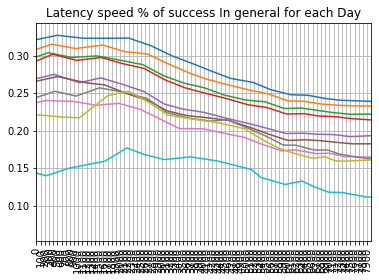

DAY =  10


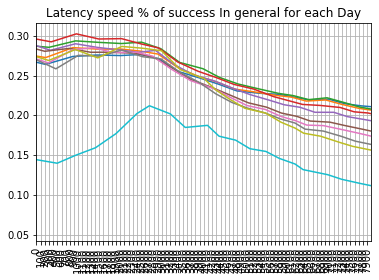

DAY =  11


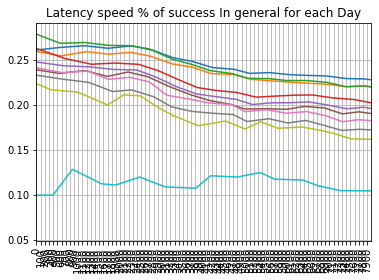

DAY =  12


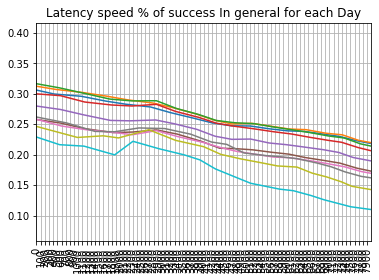

DAY =  13


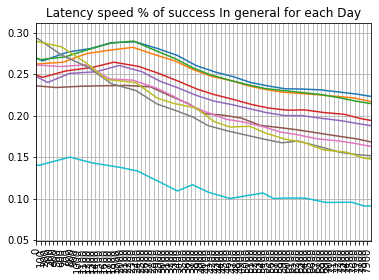

DAY =  14


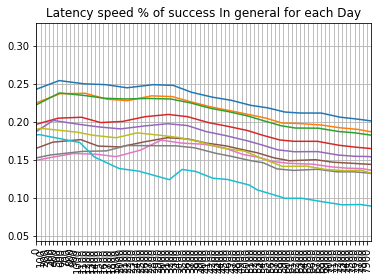

DAY =  15


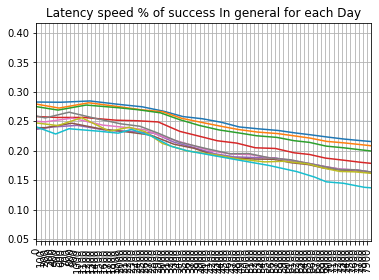

DAY =  16


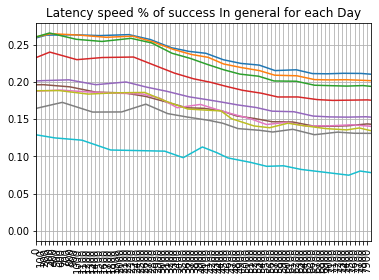

DAY =  17


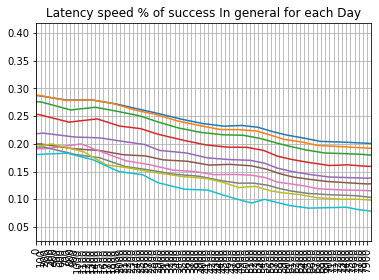

DAY =  18


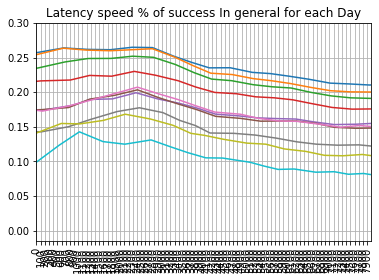

DAY =  19


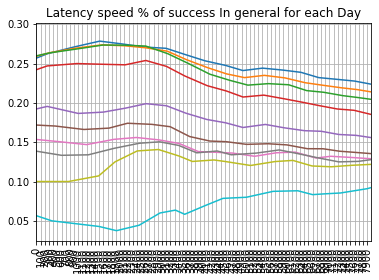

In [61]:
# Split latency into groups
# Define low latency
low = 1 # bottom 10% of latency
edge_level_stack = [0.1*i for i in range(10)]
succ_stack = []
z = 0.01
latency_stack = [z*i for i in range(int(1/z))]
x_vals = []
plt.figure(figsize=(18,10))
i = 3
for i in range(20):
    for edge_level in edge_level_stack:
        x_vals = []
        succ_stack = []

        for latency_val in latency_stack:
            x_edge = full_data.loc[full_data.DAY == i].EDGE.quantile(edge_level)
            x_latency = full_data.loc[(full_data.EDGE > x_edge ) & (full_data.DAY == i)].LATENCY.quantile(latency_val)
            L = full_data.loc[ (full_data.LATENCY < x_latency) & (full_data.EDGE > x_edge)& (full_data.DAY == i)] 
            succ_stack.append(L.SUCCESS.mean())
            x_vals.append(x_latency)

        plt.plot(x_vals,succ_stack, label="EDGE level {}".format(1-edge_level))
        plt.title("Latency speed % of success In general for each Day")

        #plt.legend()
    print("DAY = ", i)
    plt.xlim(0,8000)
    plt.xticks([i for i in range(0,8000,100)], rotation = 90)
    plt.grid()
    plt.show()

- Success rate on High Edge orders Decreases Over time

Number of Trades Below 2.8 micro second cut off

In [62]:
X = full_data.loc[full_data.LATENCY < 2.8*1000]
len(X)/len(full_data)

0.10325

Number of Trades Below 2.8 micro second cut off for High Edge Trades

In [63]:
edge_level = full_data.EDGE.quantile(0.9)
X = full_data.loc[(full_data.LATENCY < 2.8*1000) & (full_data.EDGE > edge_level)]
len(X)/len(full_data)

0.010315

# Measuring Success

## Overall Success Rate Over time

## Weighted Success rate Over time

## Success Rate on High Edge Trades within The Executable Latency range over time

[0.31295620437956206, 0.3097928436911488, 0.32019230769230766, 0.311787072243346, 0.30545112781954886, 0.29886148007590135, 0.28638059701492535, 0.3298774740810556, 0.3200379867046534, 0.27406679764243613, 0.2632075471698113, 0.28122109158186864, 0.2865384615384615, 0.24651162790697675, 0.27460629921259844, 0.2600806451612903, 0.2625482625482625, 0.26549491211840887, 0.27245508982035926]


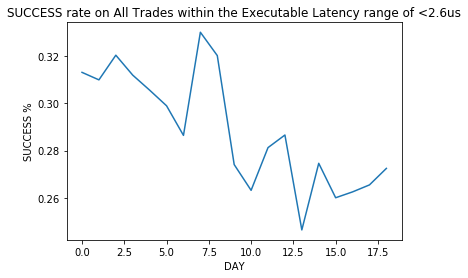

In [64]:
X = []
for i in range(20):
    if i == 5: # not including day 5
        continue
    X.append(full_data.loc[(full_data.DAY == i) & (full_data.LATENCY <= 2600)].SUCCESS.mean())

print(X)
plt.ylabel("SUCCESS %")
plt.xlabel("DAY")
plt.title("SUCCESS rate on All Trades within the Executable Latency range of <2.6us")
plt.plot(X)
    

## Success Rate on High Edge Trades within The Executable Latency range over time

[0.24050632911392406, 0.2616822429906542, 0.3162393162393162, 0.3008130081300813, 0.28019323671497587, 0.22540983606557377, 0.22885572139303484, 0.27802690582959644, 0.23737373737373738, 0.2822966507177033, 0.20398009950248755, 0.2422360248447205, 0.22580645161290322, 0.18666666666666668, 0.22748815165876776, 0.18592964824120603, 0.15730337078651685, 0.16748768472906403, 0.1388888888888889]


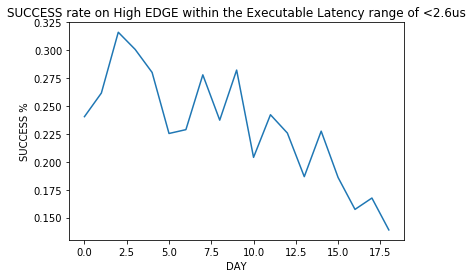

In [65]:
X = []
edge_level = 0.8
for i in range(20):
    if i == 5: # not including day 5
        continue
    x_level = full_data.EDGE.quantile(edge_level)
    X.append(full_data.loc[(full_data.DAY == i) & (full_data.LATENCY <= 2600)& (full_data.EDGE >= x_level)].SUCCESS.mean())

print(X)
plt.ylabel("SUCCESS %")
plt.xlabel("DAY")
plt.title("SUCCESS rate on High EDGE within the Executable Latency range of <2.6us")
plt.plot(X)

### Success on Low edge Trades

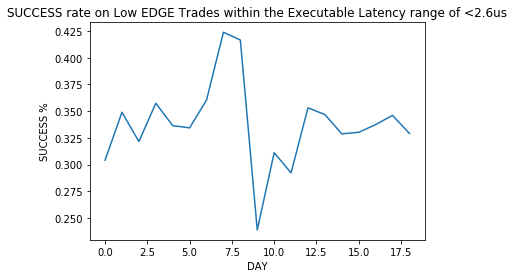

In [66]:
X = []
edge_level = 0.3
for i in range(20):
    if i == 5: # not including day 5
        continue
    x_level = full_data.EDGE.quantile(edge_level)
    X.append(full_data.loc[(full_data.DAY == i) & (full_data.LATENCY <= 2600)& (full_data.EDGE <= x_level)].SUCCESS.mean())
#
#print(X)
plt.plot(X)
plt.ylabel("SUCCESS %")
plt.xlabel("DAY")
plt.title("SUCCESS rate on Low EDGE Trades within the Executable Latency range of <2.6us")
plt.show()


Success on High Edge Trades need to be improved as the success rate falls over time

# Methods for improving

## Logistic Regression

Add new column showing position during each day

In [67]:
y = []
for i in range(20):
    y.extend([i for i in range(len(full_data.loc[full_data.DAY == i]))])

full_data["new_DAY"] = y
full_data.loc[full_data.DAY == 10].head()

,DAY,EDGE,EDGE_EUR,VOLUME,GW,LATENCY,SUCCESS,new_DAY
100021,10,0.016027,286.073550,21,3,18465,0,0
100022,10,0.006252,106.279104,20,1,18544,1,1
100023,10,0.014346,268.270538,22,3,39010,0,2
100024,10,0.002457,4.177715,2,2,10615,0,3
100025,10,0.023071,666.757177,34,3,45049,0,4


Feature Selection

In [68]:
x = full_data.columns
print(x)

Index(['DAY', 'EDGE', 'EDGE_EUR', 'VOLUME', 'GW', 'LATENCY', 'SUCCESS',
       'new_DAY'],
      dtype='object')


In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

features = ['DAY', 'EDGE', 'EDGE_EUR', 'VOLUME', 'GW', 'LATENCY',
       'new_DAY']
X = full_data[features]
y = full_data["SUCCESS"]
# Build a logreg and compute the feature importances
model = LogisticRegression()


c:\Users\joshu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


The most important feature related to success is EDGE

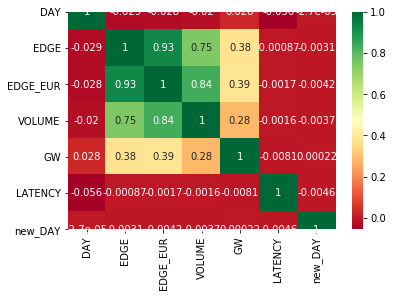

In [70]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(12,10))
#plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

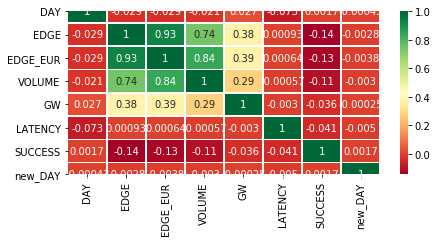

In [73]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(3,3))
#plt.subplots(figsize=(8, 5))
fig, ax = plt.subplots (figsize=(7, 3))
X = full_data
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn",linewidths=.5)
#ax.set_ylim("DAY", "IsHigh_EDGE") # set the ylim to bottom, top
plt.show()

See heatmap for full data

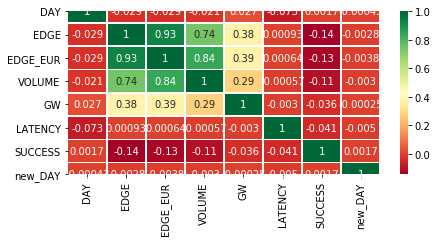

In [74]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(3,3))
#plt.subplots(figsize=(8, 5))
fig, ax = plt.subplots (figsize=(7, 3))
X = full_data
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn",linewidths=.5)
#ax.set_ylim("DAY", "IsHigh_EDGE") # set the ylim to bottom, top
plt.show()

Split The Data into Training and Test Data for validation

In [78]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
X = full_data[features]
y = full_data["SUCCESS"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression
# instantiate the model
logreg = LogisticRegression(C = 0.01,solver='liblinear', random_state=2)
# fit the model
logreg.fit(X_train, y_train)

coef = logreg.coef_[0]
print (logreg.coef_, logreg.intercept_)
print(logreg.classes_)
plt.clf()
plt.show()

[[-2.87773055e-02 -1.65808551e-05 -1.76360867e-03 -2.59009830e-02
  -4.09881859e-03 -9.15187260e-06 -5.07761513e-05]] [-0.00343675]
[0 1]


<Figure size 432x288 with 0 Axes>

Test the model on Test data

In [79]:
y_pred_test = logreg.predict(X_test)

y_pred_test

c:\Users\joshu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [80]:
# probability of getting output as 1 - Order Executes

logreg.predict_proba(X_test)[:,1]

array([0.11806355, 0.15313335, 0.22615865, ..., 0.07671306, 0.24174191,
       0.09627658])

Get Model Accuracy

In [81]:
from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score: 0.8179


Check for Over fitting

In [82]:
y_pred_train = logreg.predict(X_train)

print('Training-set accuracy score: {0:0.5f}'. format(accuracy_score(y_train, y_pred_train)))
print('Test-set accuracy score: {0:0.5f}'. format(accuracy_score(y_test, y_pred_test)))

Training-set accuracy score: 0.82014
Test-set accuracy score: 0.81788


c:\Users\joshu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


We see they are very similar so there is no overfitting

In [83]:
print(y_test.value_counts())
print(1 - y_test.mean())
print(1- y_train.mean())

0    31042
1     6912
Name: SUCCESS, dtype: int64
0.8178848079253833
0.8201393829209812


#### Repeating for only a single feature

In [85]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
features = ["EDGE", "EDGE_EUR"]
X = full_data[features]
y = full_data["SUCCESS"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression
# instantiate the model
model = LogisticRegression(solver='liblinear', random_state=3)
# fit the model
model.fit(X_train, y_train)

coef = logreg.coef_[0]
print (logreg.coef_, logreg.intercept_)
print(logreg.classes_)


###

y_pred_test = model.predict(X_test)
model.predict_proba(X_test)[:,1]
from sklearn.metrics import accuracy_score
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))


[[-2.87773055e-02 -1.65808551e-05 -1.76360867e-03 -2.59009830e-02
  -4.09881859e-03 -9.15187260e-06 -5.07761513e-05]] [-0.00343675]
[0 1]
Model accuracy score: 0.8179


c:\Users\joshu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


Model is no better than predicting every Order is unsuccessful

## Random Forest Regression

In [86]:
from sklearn.model_selection import train_test_split
features = ['DAY', 'EDGE', 'EDGE_EUR', 'VOLUME', 'GW', 'LATENCY',
       'new_DAY']
X = full_data[features]
y = full_data["SUCCESS"]

train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(train_X, train_y)
y_preds = forest_model.predict(val_X)
print(mean_absolute_error(val_y, y_preds))

c:\Users\joshu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:32: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
c:\Users\joshu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:32: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecat

0.29207453311411835


In [88]:
# make models
from sklearn.ensemble import RandomForestRegressor

# Define the models
model_1 = RandomForestRegressor(n_estimators=50, random_state=0)
model_2 = RandomForestRegressor(n_estimators=100, random_state=0)
model_3 = RandomForestRegressor(n_estimators=100, criterion='mse', random_state=0)
model_4 = RandomForestRegressor(n_estimators=200, min_samples_split=20, random_state=0)
model_5 = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=0)
RandomForestRegressor

models = [model_1, model_2, model_3, model_4, model_5]

from sklearn.metrics import mean_absolute_error

# Function for comparing different models
def score_model(model, X_t=train_X, X_v=val_X, y_t=train_y, y_v=val_y):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)

for i in range(0, len(models)):
    mae = score_model(models[i])
    print("Model %d MAE: %d" % (i+1, mae))

c:\Users\joshu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


Model 1 MAE: 0


# Conclusion

The largest factor on Success (for a given EDGE) is Latency and Gateway
- We see that as EDGE increases Success decreases as expected
- We see that GW 2 performs the best, and has the highest success rate over time for a given EDGE
- In order to increase success, we must aim to decrease latency to below 2.6 us for all EDGE trades, and increase usage of GW 2
